In [20]:
suppressMessages(library(data.table))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(repr))
options(dplyr.summarise.inform = FALSE)

In [3]:
# Do not execute this. Kernel will be aborted due to larget data size
# cdc.source.csv <- "COVID-19_Case_Surveillance_Public_Use_Data_with_Geography.csv.gz"
# 5/10/2021 updates https://data.cdc.gov/api/views/n8mc-b4w4/rows.csv?accessType=DOWNLOAD
# Dictionary https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data-with-Ge/n8mc-b4w4
# Variable summary https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data-with-Ge/ynhu-f2s2

# read CDC 19 column dataset
data <- fread(cdc.source.csv, 
          colClasses = list(factor = c( "case_month", 
                                        "res_state", 
                                        "state_fips_code", 
                                        "age_group", 
                                        "sex", 
                                        "race", 
                                        "ethnicity", 
                                        "process", 
                                        "exposure_yn", 
                                        "current_status", 
                                        "symptom_status", 
                                        "hosp_yn", 
                                        "icu_yn", 
                                        "death_yn", 
                                        "underlying_conditions_yn"), 
                            character = c("res_county", 
                                          "county_fips_code"),
                            integer = c("case_positive_specimen_interval", 
                                        "case_onset_interval")))


# remove unconfirmed cases and recode ethnicity as "Hispanic White", "Non-His White", "Non-His Asian", "Non-His Black"
# this removed 10+% of the records
data <- data %>%  
          filter(current_status == "Laboratory-confirmed case") %>%
          rename(original_ethnicity = ethnicity) %>%
          mutate(ethnicity = case_when(
                                  race == "White" & original_ethnicity == "Non-Hispanic/Latino" ~ "Non-His White",
                                  race == "Asian" & original_ethnicity == "Non-Hispanic/Latino" ~ "Non-His Asian",
                                  race == "Black" & original_ethnicity == "Non-Hispanic/Latino" ~ "Non-His Black",
                                  race == "White" & original_ethnicity == "Hispanic/Latino" ~ "Hispanic White")) %>%
          select(-c(current_status, race, original_ethnicity, exposure_yn)) %>%
          setDT()
saveRDS(data, file="cdc_May102021_22M_trimmed_record.rds")


# Remove records with incomplete geo information, unknown age_group, sex, mortality, unconfirmed cases, and 
# ethnicity not in the 4 categories above. This left us with about 20% of the total records.
data2 <- data %>%
             filter(!is.na(res_state) & 
                    !is.na(state_fips_code) & 
                    !is.na(county_fips_code) &
                    !is.na(res_county) &
                    !is.na(age_group) & 
                    age_group != "Missing" & 
                    sex %in% c("Female", "Male") & 
                    !is.na(ethnicity) & 
                    death_yn %in% c("Yes", "No")) %>%
             filter(!is.na(ethnicity)) %>%  
             mutate(sex = factor(sex),
                    age_group = factor(age_group), 
                    ethnicity = factor(ethnicity, levels = c("Non-His Asian", "Non-His Black", "Non-His White", "Hispanic White"))) %>%
             setDT()             
saveRDS(data2, file="cdc_May102021_5M_trimmed_record.rds")
data3 <- data2[case_onset_interval==0]         
saveRDS(data3, file="cdc_May102021_3M_trimmed_record.rds")

In [1]:
data3 <- readRDS("cdc_May102021_3M_trimmed_record.rds")

### Case Count by Gender & Ethnicity Group

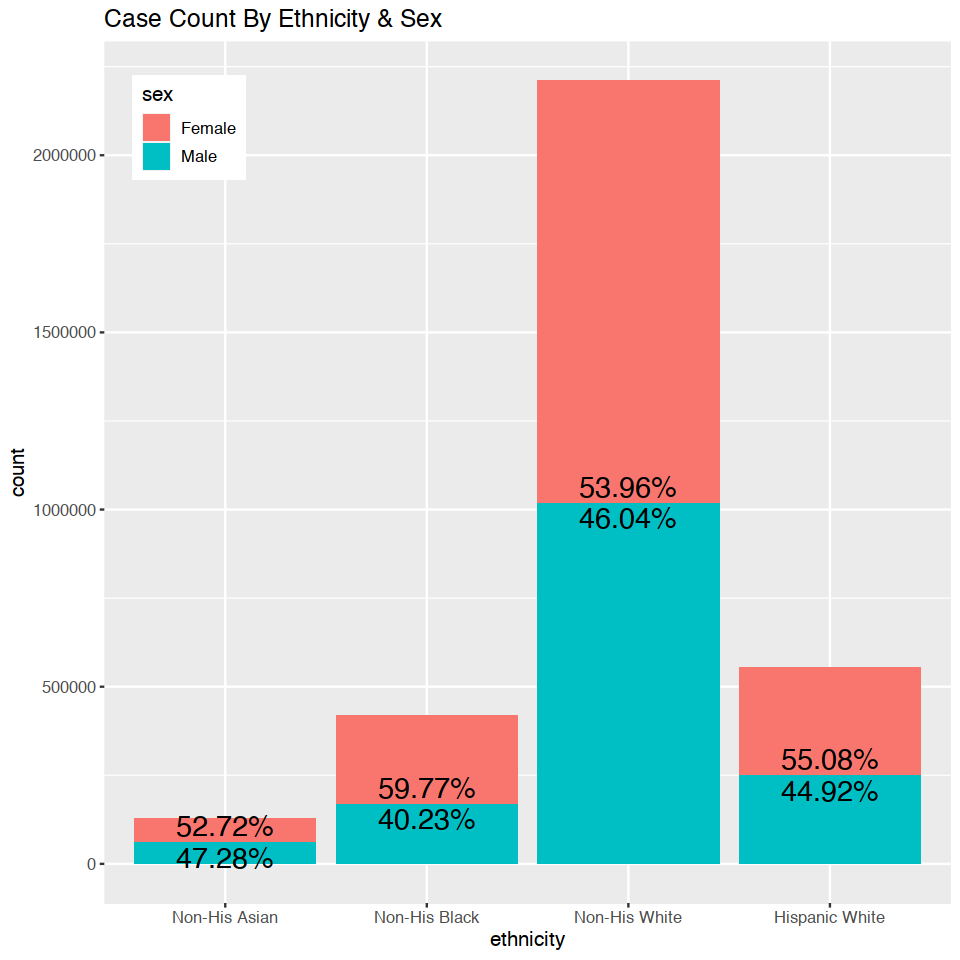

In [24]:
ethnicity_sex_prop <- data3 %>% 
        group_by(ethnicity) %>% 
        summarise(male = sum(sex=="Male"), 
                  female = sum(sex=="Female"), 
                  proportion_female = female / (male + female), 
                  percentage_female = paste0(round( proportion_female * 100, digit=2), "%"), 
                  percentage_male = paste0(round( (1 - proportion_female) * 100, digit=2), "%")) %>%
        setDT()
options(repr.plot.width=8, repr.plot.height=8)
ggplot(data3) + 
        geom_bar(aes(x=ethnicity, fill=sex)) + 
        geom_text(data = ethnicity_sex_prop, aes(x=ethnicity, y=male, label=percentage_female, vjust=-0.3), size=6) + 
        geom_text(data = ethnicity_sex_prop, aes(x=ethnicity, y=male, label=percentage_male, vjust=1.2), size=6) + 
        ggtitle("Case Count By Ethnicity & Sex") + 
        theme(legend.position = c(0.1, 0.9)) + 
        theme(text = element_text(size=12))

### Fatality Rate By Ethnicity Groups

In [7]:
data3 %>% 
        group_by(ethnicity) %>% 
        summarise(fatality_count = sum(death_yn == "Yes"), 
                  case_count = n(),
                  fatality_rate = paste0(round(fatality_count/case_count * 100, digit=2), "%")) 

ethnicity,fatality_count,case_count,fatality_rate
<fct>,<int>,<int>,<chr>
Non-His Asian,2727,126684,2.15%
Non-His Black,10249,417950,2.45%
Non-His White,55185,2210789,2.5%
Hispanic White,10194,553601,1.84%


### Case Count by Gender & Ethnicity

In [9]:
data3 %>% 
        group_by(ethnicity) %>% 
        summarise(male = sum(sex=="Male"), 
                  female = sum(sex=="Female"), 
                  proportion_female = female / (male + female), 
                  percentage_female = paste0(round( proportion_female * 100, digit=2), "%"))

ethnicity,male,female,proportion_female,percentage_female
<fct>,<int>,<int>,<dbl>,<chr>
Non-His Asian,59893,66791,0.5272252,52.72%
Non-His Black,168159,249791,0.5976576,59.77%
Non-His White,1017802,1192987,0.5396205,53.96%
Hispanic White,248668,304933,0.5508173,55.08%


### Female vs. Male Fatality Ratio

In [10]:
data3 %>% 
          group_by(ethnicity, age_group) %>% 
          summarise(fatality_ratio = sum(death_yn == "Yes" & sex == "Female")/ sum(sex == "Female") / sum(death_yn == "Yes" & sex == "Male") * sum(sex == "Male")) %>%
          filter(!is.nan(fatality_ratio))

ethnicity,age_group,fatality_ratio
<fct>,<fct>,<dbl>
Non-His Asian,18 to 49 years,0.00000000
Non-His Asian,50 to 64 years,0.08617491
Non-His Asian,65+ years,0.66096400
Non-His Black,18 to 49 years,0.43887139
Non-His Black,50 to 64 years,0.36687383
Non-His Black,65+ years,0.66180610
Non-His White,18 to 49 years,0.04896289
Non-His White,50 to 64 years,0.26783007
Non-His White,65+ years,0.81196561


### Fatality Rate by Age & Ethnicity Groups

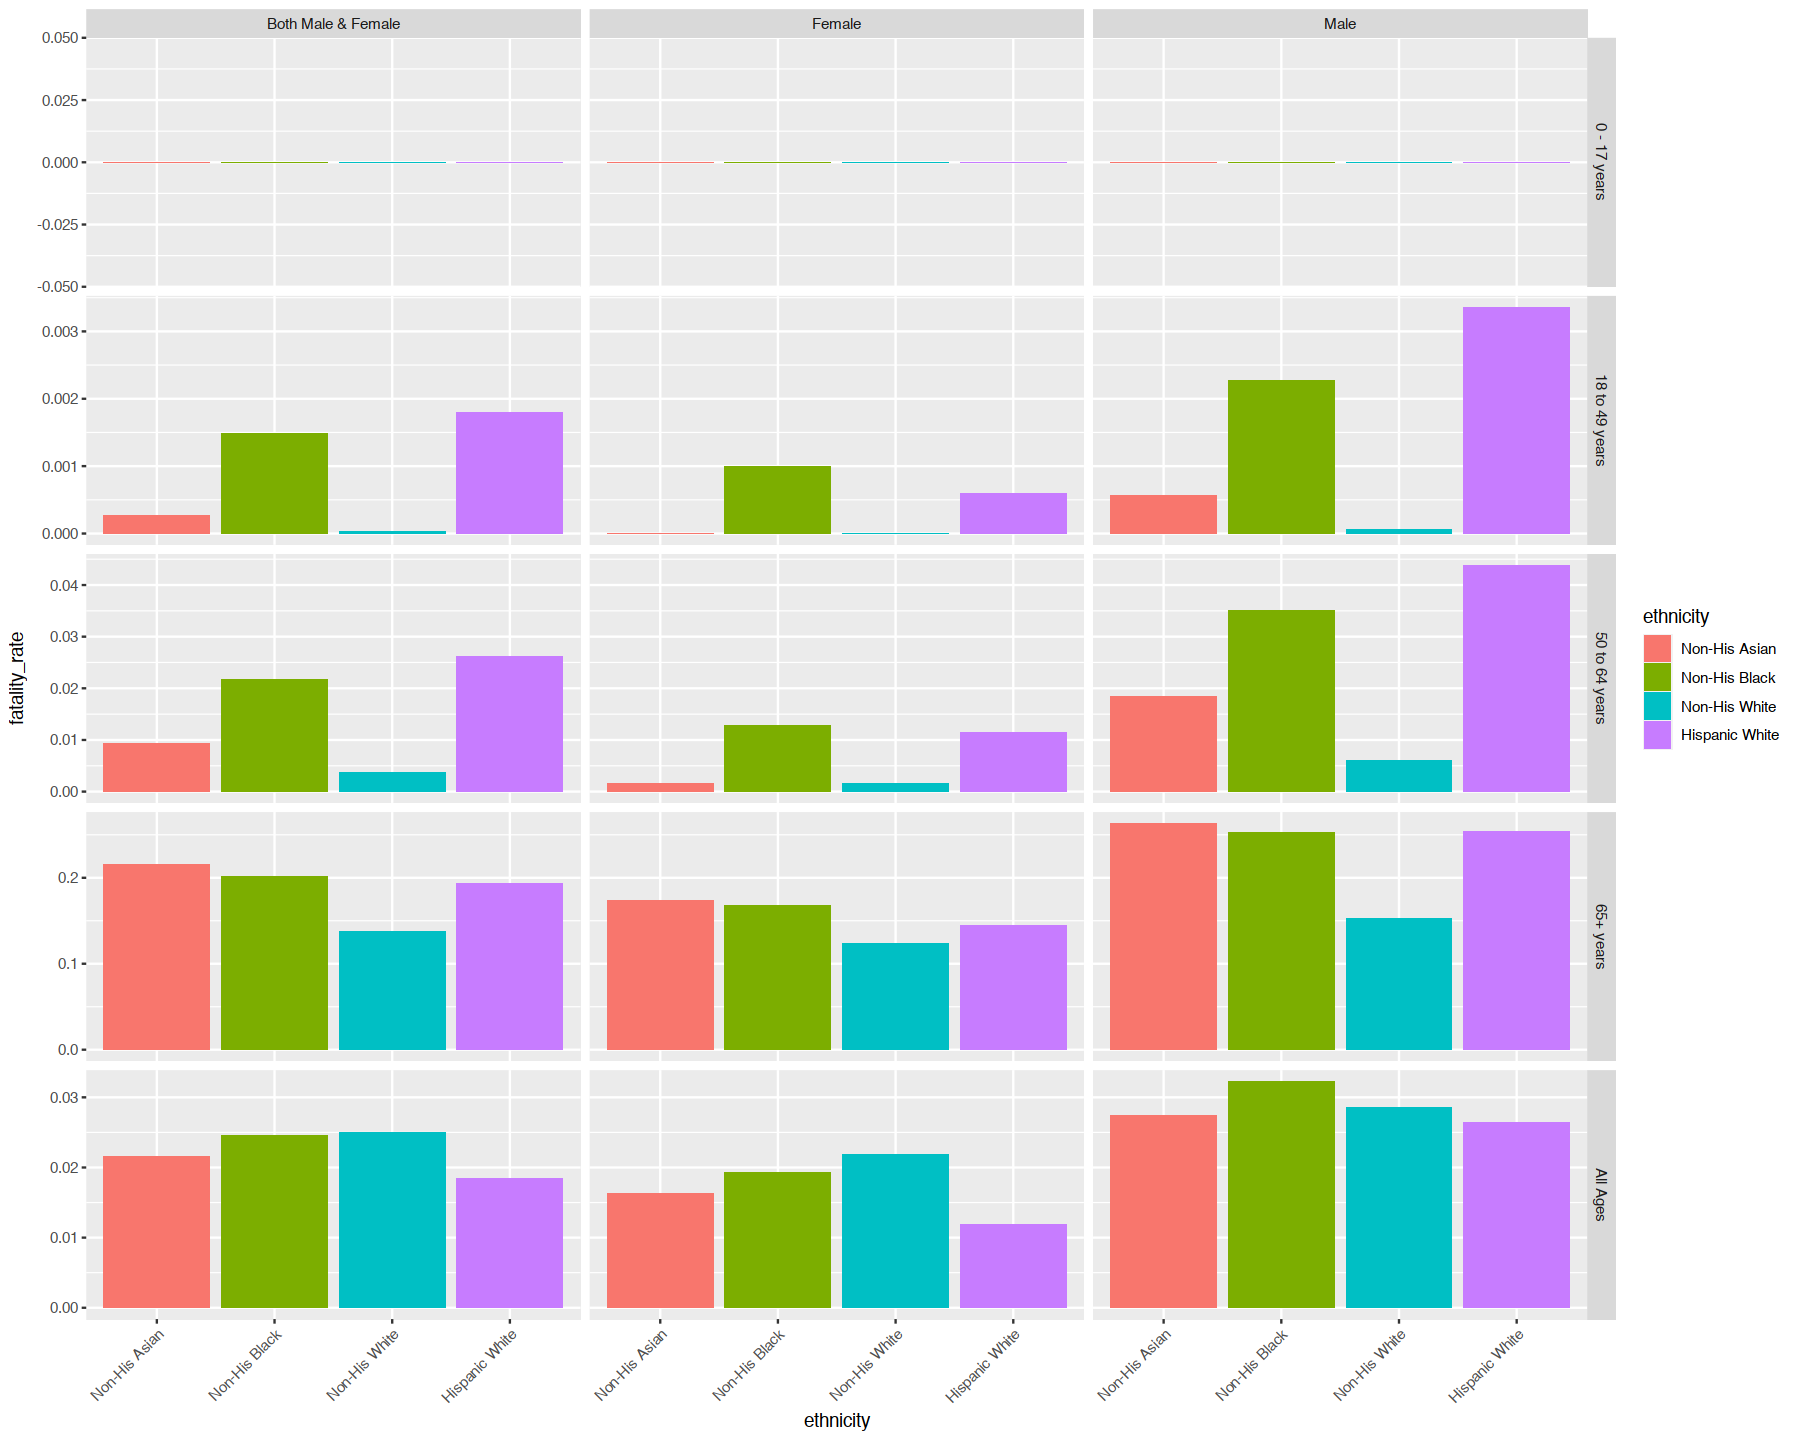

In [26]:
fatality_rate_age_sex <- data3 %>% 
          filter(!case_month %in% c("2020-01", "2020-02")) %>%
          group_by(ethnicity, age_group, sex) %>% 
          summarise(fatality_rate = sum(death_yn == "Yes")/ n()) 
fatality_rate_age <- data3 %>% 
          filter(!case_month %in% c("2020-01", "2020-02")) %>%
          group_by(ethnicity, age_group) %>% 
          summarise(fatality_rate = sum(death_yn == "Yes")/ n()) %>%
          mutate(sex = "Both Male & Female") 
fatality_rate_sex <- data3 %>% 
          filter(!case_month %in% c("2020-01", "2020-02")) %>%
          group_by(ethnicity, sex) %>% 
          summarise(fatality_rate = sum(death_yn == "Yes")/ n()) %>%
          mutate(age_group = "All Ages") 
fatality_rate <- data3 %>% 
          filter(!case_month %in% c("2020-01", "2020-02")) %>%
          group_by(ethnicity) %>% 
          summarise(fatality_rate = sum(death_yn == "Yes")/ n()) %>%
          mutate(age_group = "All Ages",
                 sex = "Both Male & Female")
d1 <- rbind(fatality_rate_age_sex, fatality_rate_age, fatality_rate_sex, fatality_rate)

options(repr.plot.width=15, repr.plot.height=12)
ggplot(d1, aes(ethnicity, fatality_rate, fill=ethnicity)) + 
       geom_bar(stat="identity") + 
       theme(axis.text.x=element_text(angle=45, vjust=1, hjust=1)) +
       facet_grid(age_group ~ sex, scales = "free_y")

### Fatality Rate by Month & Ethnicity Groups

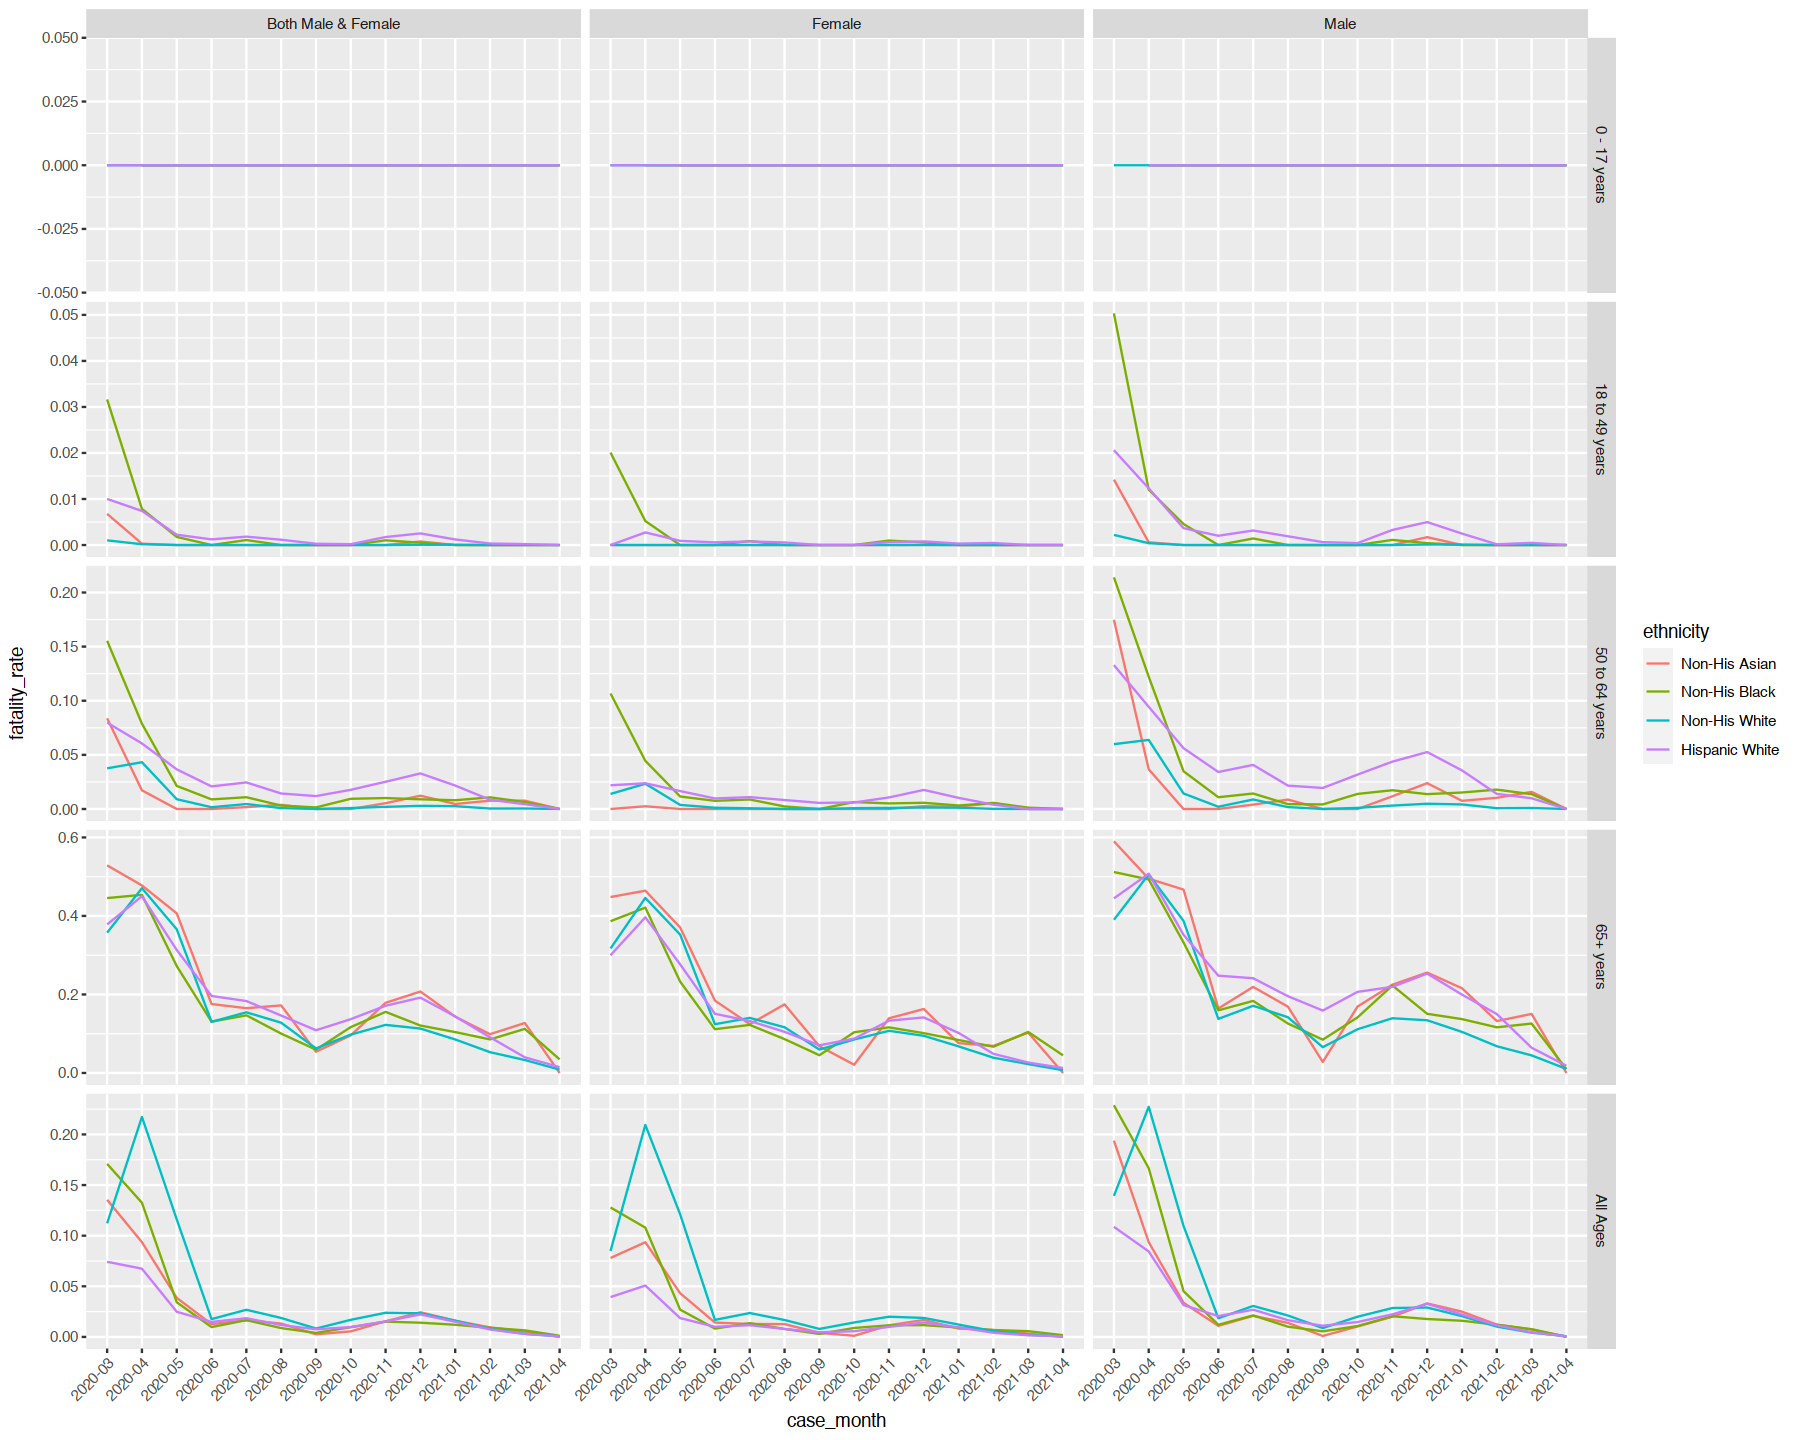

In [23]:
monthly_fatality_rate_age_sex <- data3 %>% 
          filter(!case_month %in% c("2020-01", "2020-02")) %>%
          group_by(case_month, ethnicity, age_group, sex) %>% 
          summarise(fatality_rate = sum(death_yn == "Yes")/ n()) 
monthly_fatality_rate_age <- data3 %>% 
          filter(!case_month %in% c("2020-01", "2020-02")) %>%
          group_by(case_month, ethnicity, age_group) %>% 
          summarise(fatality_rate = sum(death_yn == "Yes")/ n()) %>%
          mutate(sex = "Both Male & Female") 
monthly_fatality_rate_sex <- data3 %>% 
          filter(!case_month %in% c("2020-01", "2020-02")) %>%
          group_by(case_month, ethnicity, sex) %>% 
          summarise(fatality_rate = sum(death_yn == "Yes")/ n()) %>%
          mutate(age_group = "All Ages") 
monthly_fatality_rate <- data3 %>% 
          filter(!case_month %in% c("2020-01", "2020-02")) %>%
          group_by(case_month, ethnicity) %>% 
          summarise(fatality_rate = sum(death_yn == "Yes")/ n()) %>%
          mutate(age_group = "All Ages",
                 sex = "Both Male & Female") 
d2 <- rbind(monthly_fatality_rate_age_sex, monthly_fatality_rate_age, monthly_fatality_rate_sex, monthly_fatality_rate)
ggplot(d2, aes(case_month, fatality_rate, group=ethnicity, col=ethnicity)) + 
       geom_line() + 
       theme(axis.text.x=element_text(angle=45, vjust=1, hjust=1)) +
       facet_grid(age_group ~ sex, scales = "free_y")

### Summarize Data for Linear Model 

In [28]:
phase_fatality_rate <- data3 %>% 
          filter(!case_month %in% c("2020-01", "2020-02")) %>%
          group_by(case_month, ethnicity, age_group, sex) %>% 
          summarise(case_count = n(),
                    fatality_count = sum(death_yn == "Yes"),
                    fatality_rate = fatality_count/ case_count) %>%
          filter(fatality_count >= 10) %>%
          setDT()
print(phase_fatality_rate)

     case_month      ethnicity      age_group    sex case_count fatality_count
  1:    2020-03  Non-His Asian 50 to 64 years   Male        372             65
  2:    2020-03  Non-His Asian      65+ years Female        232            104
  3:    2020-03  Non-His Asian      65+ years   Male        305            180
  4:    2020-03  Non-His Black 18 to 49 years Female       3635             73
  5:    2020-03  Non-His Black 18 to 49 years   Male       2245            113
 ---                                                                          
196:    2021-03 Hispanic White      65+ years Female        792             21
197:    2021-03 Hispanic White      65+ years   Male        436             28
198:    2021-04  Non-His Black      65+ years Female        490             22
199:    2021-04  Non-His White      65+ years Female       3719             26
200:    2021-04  Non-His White      65+ years   Male       3113             32
     fatality_rate
  1:   0.174731183
  2:   0.44827

In [29]:
l1 <- lm(log10(fatality_rate) ~ sex + case_month + ethnicity + age_group, data = phase_fatality_rate)
summary(l1)


Call:
lm(formula = log10(fatality_rate) ~ sex + case_month + ethnicity + 
    age_group, data = phase_fatality_rate)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.68214 -0.15177 -0.00446  0.15555  0.67434 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -2.271369   0.091151 -24.919  < 2e-16 ***
sexMale                  0.295846   0.035712   8.284 2.64e-14 ***
case_month2020-04       -0.117518   0.080544  -1.459    0.146    
case_month2020-05       -0.430433   0.082970  -5.188 5.69e-07 ***
case_month2020-06       -0.760262   0.086084  -8.832 9.06e-16 ***
case_month2020-07       -0.686723   0.083021  -8.272 2.85e-14 ***
case_month2020-08       -0.800001   0.092349  -8.663 2.59e-15 ***
case_month2020-09       -0.947925   0.111925  -8.469 8.53e-15 ***
case_month2020-10       -0.891865   0.090215  -9.886  < 2e-16 ***
case_month2020-11       -0.769672   0.080544  -9.556  < 2e-16 ***
case_month2020-12       -0.716640   0

### Regressor Fatality Rate Change by Month

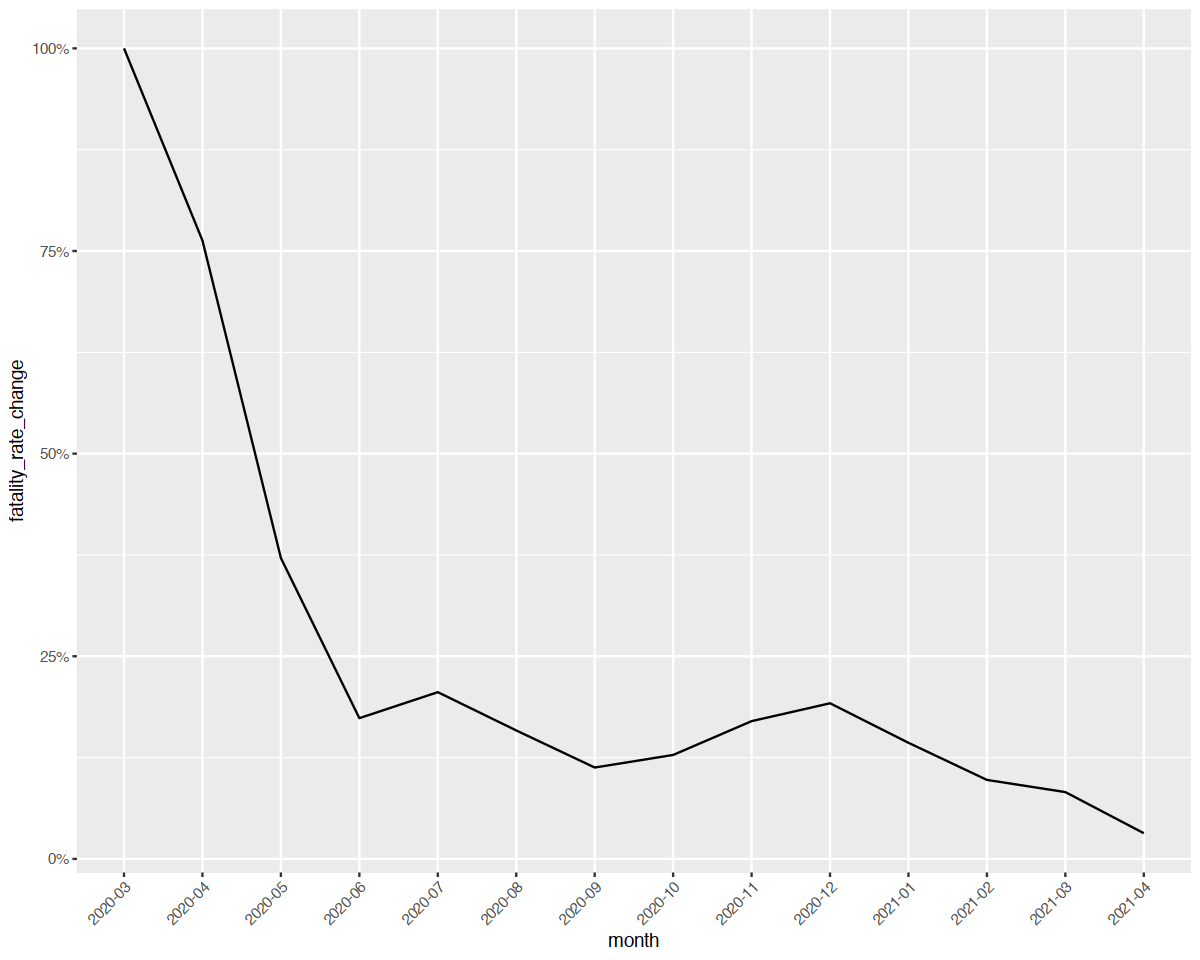

In [32]:
coef <- data.table(variable = names(l1$coefficients), beta = l1$coefficients) %>%
          filter(grepl("case_month", variable)) %>%
          rename(month = "variable") %>%
          mutate(month = gsub("case_month", "", month)) %>% 
          add_row(month = "2020-03", beta = 0) %>%
          mutate(fatality_rate_change = 10^beta) %>%
          setDT() 

options(repr.plot.width=10, repr.plot.height=8)
ggplot(coef, aes(month, fatality_rate_change, group=1)) + 
    geom_line() +
    theme(axis.text.x=element_text(angle=45, vjust=1, hjust=1)) + 
    scale_y_continuous(labels = scales::percent)